Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/drive/MyDrive/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

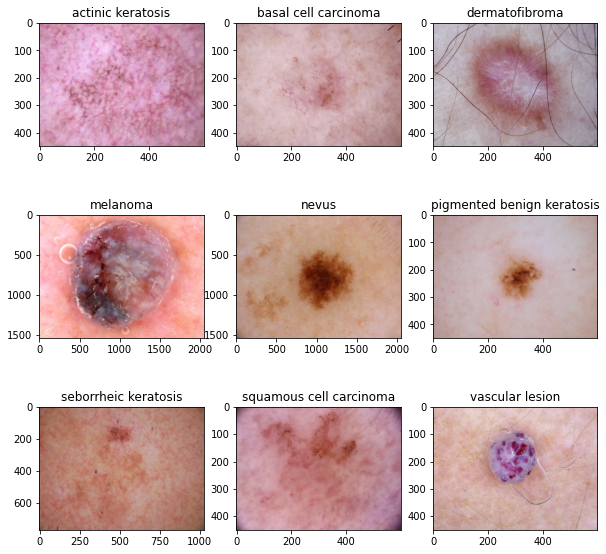

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 225s 915ms/step - loss: 2.0249 - accuracy: 0.2154 - val_loss: 1.7692 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 9s 152ms/step - loss: 1.8159 - accuracy: 0.3583 - val_loss: 1.7386 - val_accuracy: 0.3915
Epoch 3/20
56/56 [==============================] - 8s 150ms/step - loss: 1.7344 - accuracy: 0.3756 - val_loss: 1.8399 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 8s 150ms/step - loss: 1.6467 - accuracy: 0.4057 - val_loss: 1.6031 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 8s 150ms/step - loss: 1.5623 - accuracy: 0.4342 - val_loss: 1.5212 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 8s 150ms/step - loss: 1.5702 - accuracy: 0.4297 - val_loss: 1.5310 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 8s 151ms/step - loss: 1.4546 - accuracy: 0.4833 - val_loss: 1.5884 - val_accuracy: 0.4407
Epoch 8/20
56/5

### Visualizing training results

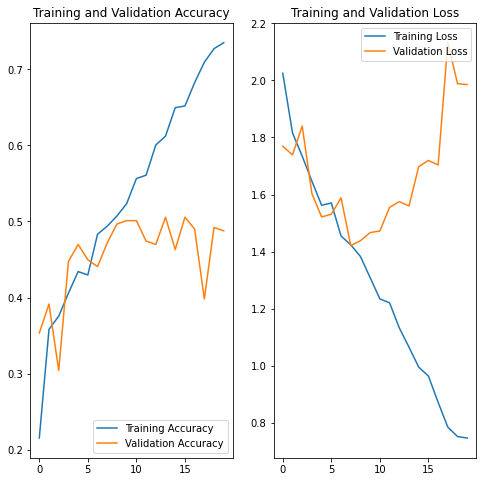

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here

#### Findings are as follows:

##### 1)The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

##### 2) The accuracy is just around 75-80% because there are enough features to remember the pattern.




In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


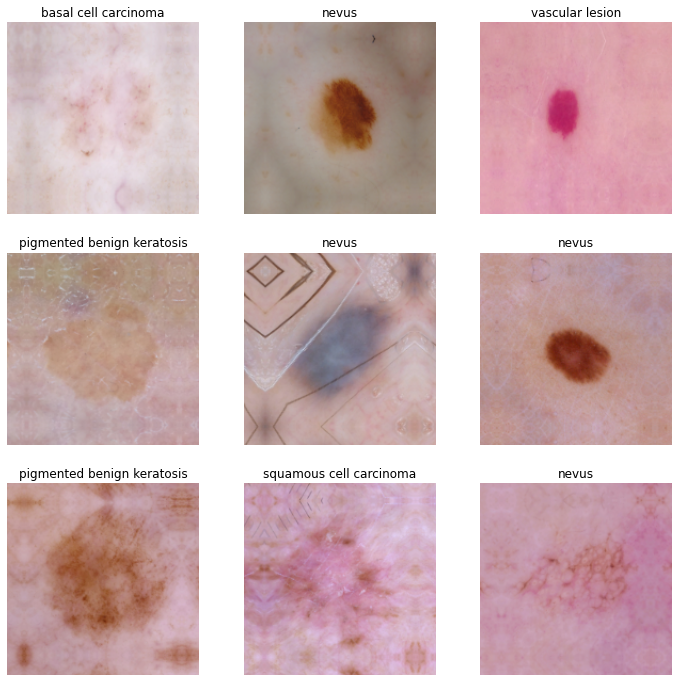

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))




### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [25]:

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) ## your training code

Epoch 1/30
56/56 [==============================] - 9s 166ms/step - loss: 2.0445 - accuracy: 0.2171 - val_loss: 2.0328 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 9s 166ms/step - loss: 2.0191 - accuracy: 0.2199 - val_loss: 2.0295 - val_accuracy: 0.2058
Epoch 3/30
56/56 [==============================] - 9s 166ms/step - loss: 2.0211 - accuracy: 0.2020 - val_loss: 2.0317 - val_accuracy: 0.2081
Epoch 4/30
56/56 [==============================] - 9s 166ms/step - loss: 2.0641 - accuracy: 0.2148 - val_loss: 2.0263 - val_accuracy: 0.2148
Epoch 5/30
56/56 [==============================] - 9s 166ms/step - loss: 2.0200 - accuracy: 0.2115 - val_loss: 2.0278 - val_accuracy: 0.2013
Epoch 6/30
56/56 [==============================] - 9s 166ms/step - loss: 2.0180 - accuracy: 0.2143 - val_loss: 1.9933 - val_accuracy: 0.2864
Epoch 7/30
56/56 [==============================] - 9s 166ms/step - loss: 1.9905 - accuracy: 0.2377 - val_loss: 1.9288 - val_accuracy: 0.2886
Epoch 

### Visualizing the results

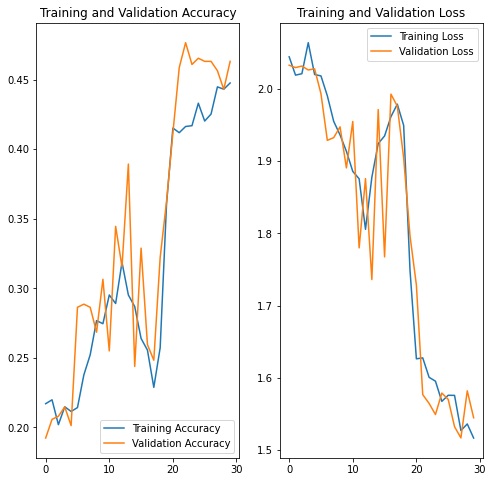

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

##### Findings are as follows:
##### 1) There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

#####2)We can increase the epochs to increase the accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
1,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
2,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
3,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
4,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2235,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2236,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2237,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion


In [28]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
1,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
2,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
3,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
4,/content/drive/MyDrive/Train/actinic keratosis...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2235,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2236,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion
2237,/content/drive/MyDrive/Train/vascular lesion/I...,vascular lesion


<BarContainer object of 9 artists>

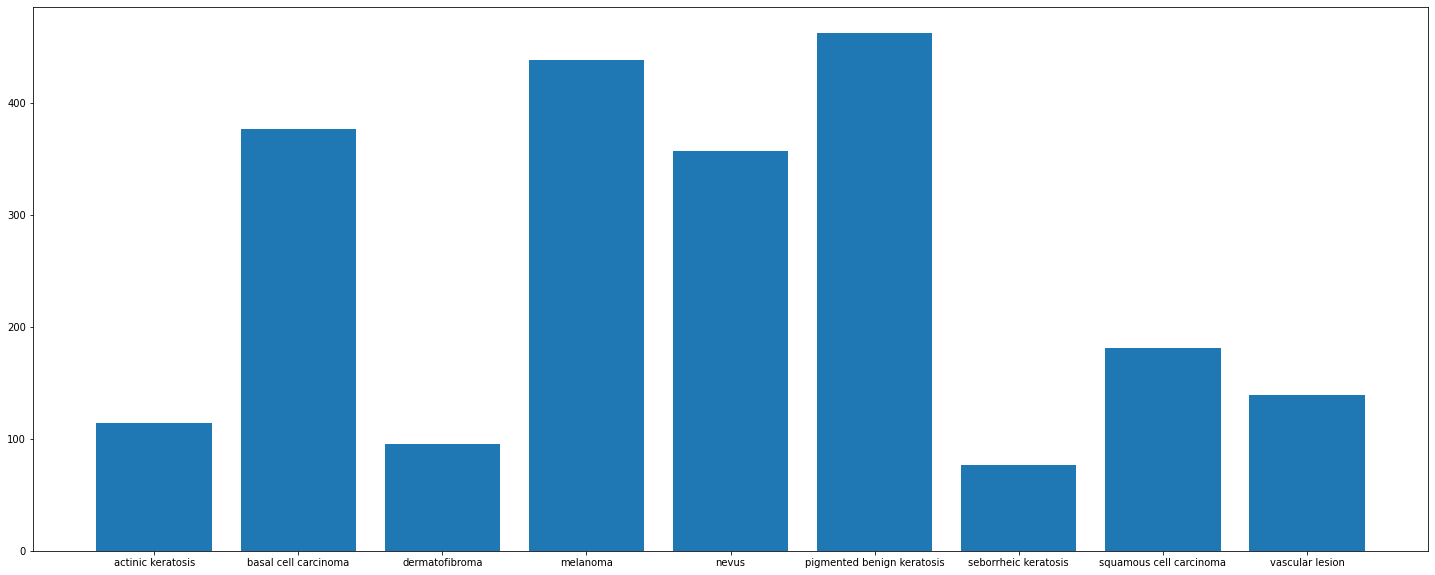

In [29]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

##### - squamous cell carcinoma has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?

#####- actinic keratosis and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset="/content/drive/MyDrive/Train"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F83276EA7D0>: 100%|██████████| 500/500 [00:53<00:00,  9.31 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F832769A790>: 100%|██████████| 500/500 [00:49<00:00, 10.00 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F839BF37E10>: 100%|██████████| 500/500 [00:51<00:00,  9.70 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F839ACEE890>: 100%|██████████| 500/500 [00:52<00:00,  9.47 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F83277B0FD0>: 100%|██████████| 500/500 [00:50<00:00, 10.00 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F839ABCC490>: 100%|██████████| 500/500 [00:53<00:00,  9.43 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F839BF2D090>: 100%|██████████| 500/500 [00:45<00:00, 10.93 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F83277F6D90>: 100%|██████████| 500/500 [01:01<00:00,  8.19 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F839AE93090>: 100%|██████████| 500/500 [00:45<00:00, 10.91 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [50]:
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)
data_dir_train = pathlib.Path("/content/drive/MyDrive/Train")

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [56]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

[]

In [57]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

[]

In [58]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [59]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [60]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [64]:
data_dir_train= pathlib.Path("/content/drive/MyDrive/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [66]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [67]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [68]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 49s 279ms/step - loss: nan - accuracy: 0.0197 - val_loss: nan - val_accuracy: 0.0230
Epoch 2/50
169/169 [==============================] - 47s 270ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 3/50
169/169 [==============================] - 47s 269ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 4/50
169/169 [==============================] - 47s 269ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 5/50
169/169 [==============================] - 47s 270ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 6/50
169/169 [==============================] - 47s 271ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 7/50
169/169 [==============================] - 47s 272ms/step - loss: nan - accuracy: 0.0154 - val_loss: nan - val_accuracy: 0.0230
Epoch 8/50
169/169 [==================

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
### *Accuracy on training data has increased by using Augmentor library

### *Model is still overfitting

### *The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

### *The Model can be further improved by tuning the hyperparameter